<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin_Wavenet_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chargement des données

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

On télécharge un script depuis Github permettant de télécharger un fichier stocké sur GoogleDrive, puis on utilise ce script écrit en Python pour télécharger le fichier `bitcoin.zip`. Enfin, on décompresse les données pour obtenir le fichier `bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv` :

In [5]:
# Récupération des données au format .csv

!git clone https://github.com/chentinghao/download_google_drive.git
!python download_google_drive/download_gdrive.py "1FZsEdpBm-AQ2L9n_pMnm6336-O_IVo7z" "/content/bitcoin.zip"
!unzip bitcoin.zip

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
100MB [00:01, 93.6MB/s] 
Archive:  bitcoin.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


Charge la série sous Pandas et affiche les informations du fichier :

In [6]:
# Création de la série sous Pandas
serie = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


# Pré-traitement des données

**1. Recherche des erreurs dans les données**

On commence par vérifier qu'il ne manque pas de dates. Pour cela, on vérifie qu'il y a bien 60 secondes entre deux Timestamp. Si on trouve un décalage non cohérent, on enregistre les informations dans une liste.

In [9]:
# Fonction permettant de vérifier si chaque intervalle est bien de 60s
def recherche_erreur(fenetre):
  if fenetre.values[1] - fenetre.values[0] != 60:
    Timestamp_Errors.append(fenetre.values)
  return 0

# Définit une liste pour sauvegarder le résultat des recherches
Timestamp_Errors = []

# Applique la fonction sur une fenêtre glissante des données
#serie.Timestamp.rolling(2).apply(recherche_erreur)

On affiche les erreurs trouvées :

In [10]:
# Affiche les informations sur les erreurs trouvées

for erreur in Timestamp_Errors:
  print (pd.to_datetime(Timestamp_Errors[0],unit="s"))
  print((Timestamp_Errors[0][1] - Timestamp_Errors[0][0])/60 - 1)

On observe qu'il manque des données entre le 5 janvier 2015 à 9:12:00 et le 9 janvier 2015 à 21:05:00, soit 6472 données.

Recherchons maintenant le nombre de données manquantes :

In [11]:
# Affichage du nombre total de données manquantes

data_manquantes = sum(np.isnan(serie['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 1243608


On a donc en tout : 6472 + 1243608 = 1250080 données manquantes.

**2. Identification des erreurs**

On convertit maintenant les `Timestamp` (mesure de temps exprimé en seconde écoulé depuis le 01/01/1970 - 00:00:00 UTC) en format plus standard :

In [12]:
# Conversion des timestamp en date
serie.Timestamp = pd.to_datetime(serie['Timestamp'], unit="s")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


On demande maintenant à échantillonner les données sur 60 secondes :

In [13]:
# Echantillonnage de la série sur 1min
serie_minute = serie.set_index('Timestamp').resample('60s').asfreq()

# Récupère le nombre de données sans valeurs numériques
data_manquantes = sum(np.isnan(serie_minute['Open']))

# Affiche le nombre de données manquantes et la série sur 1min 
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 1250080


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


On obtient en tout 4863849 données après échantillonnage, soit (4863849-4857377) =  6472 données supplémentaires. Ceci est cohérent avec ce qu'on avait trouvé avant. Il manque 1250080 données. 

**3. Correction des données**

Pour corriger les données, on va tout simplement utiliser la fonction [fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) de Pandas avec la fonctionnalité de type `backfill` :

In [14]:
# Applique la fonction de remplissage automatique des données non numérique avec l'option backfill
serie_minute = serie_minute.interpolate(method="slinear")
serie_minute = serie_minute.fillna(method="backfill")

In [15]:
# Récupère le nombre de données non numériques et affiche les informations

data_manquantes = sum(np.isnan(serie_minute['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.390000
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.390000
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.390000
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.390000
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


**4. Affichage des données**

Text(0.5, 1.0, 'Evolution du prix du BTC')

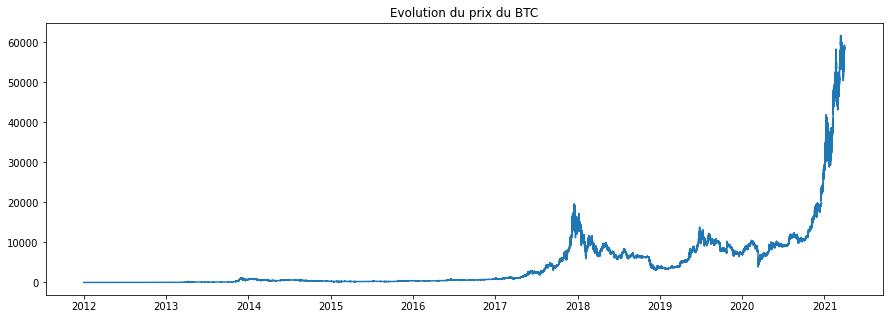

In [16]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie_minute.index, serie_minute.Open)
plt.title("Evolution du prix du BTC")

# Préparation des données

Nous allons réaliser des modélisations sur la série journalière, et pour une période allant du 1er avril 2013 au 31 mars 2021.

**1. Création de la série horaire pour la modélisation globale**

On va réaliser des prédictions à l'aide d'une série à fréquence journalière. On commence par tenter d'estimer les données manquantes à l'aide d'une interpolation linéaire à l'aide de la fonction [interpolate](https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate) de Pandas, puis on complète avec la méthode `backfill` si nécessaire.

In [17]:
# Echantillonne la série sur 1 heure
serie_heure = serie.set_index('Timestamp').resample('1H').asfreq()

# Remplissage des données non numériques par interpolation linéraire
serie_heure = serie_heure.interpolate(method="slinear")

# Remplissage des données non numériques restantes par backfill
serie_heure = serie_heure.fillna(method="backfill")

# Affiche les informations
data_manquantes = sum(np.isnan(serie_heure['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_heure

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2011-12-31 08:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2011-12-31 09:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2011-12-31 10:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2011-12-31 11:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
...,...,...,...,...,...,...,...
2021-03-30 20:00:00,59118.91,59135.00,59023.96,59037.79,2.684344,158619.612840,59090.651748
2021-03-30 21:00:00,58644.04,58670.91,58591.06,58591.06,9.979587,585005.680240,58620.228970
2021-03-30 22:00:00,58758.44,58762.56,58758.44,58762.56,0.573484,33699.187441,58762.179612


Text(0.5, 1.0, 'Evolution du prix du BTC')

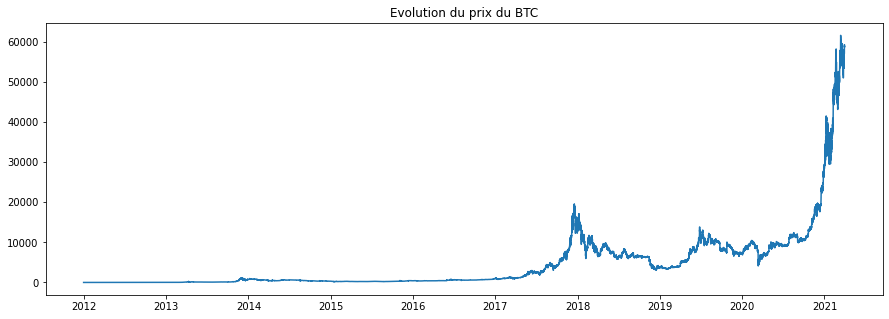

In [18]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie_heure.index, serie_heure.Open)
plt.title("Evolution du prix du BTC")

On construit une nouvelle série avec les dates retenues pour le début et la fin :

In [19]:
# Définition des dates de début et de fin

date_debut = "2013-04-01 00:00:00"
date_fin = "2021-03-31 00:00:00"

serie_etude = serie_heure.loc[date_debut:date_fin].copy()
serie_etude

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2013-04-01 00:00:00,95.373684,95.373684,95.373684,95.373684,2.154868,206.698263,95.373684
2013-04-01 01:00:00,95.463158,95.463158,95.463158,95.463158,2.311941,221.801368,95.463158
2013-04-01 02:00:00,95.552632,95.552632,95.552632,95.552632,2.469013,236.904474,95.552632
2013-04-01 03:00:00,95.642105,95.642105,95.642105,95.642105,2.626086,252.007579,95.642105
2013-04-01 04:00:00,95.731579,95.731579,95.731579,95.731579,2.783158,267.110684,95.731579
...,...,...,...,...,...,...,...
2021-03-30 20:00:00,59118.910000,59135.000000,59023.960000,59037.790000,2.684344,158619.612840,59090.651748
2021-03-30 21:00:00,58644.040000,58670.910000,58591.060000,58591.060000,9.979587,585005.680240,58620.228970
2021-03-30 22:00:00,58758.440000,58762.560000,58758.440000,58762.560000,0.573484,33699.187441,58762.179612


In [20]:
serie_etude['x'] = np.linspace(0,serie_etude.index.size-1,serie_etude.index.size)
serie_etude

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,x
Timestamp,,,,,,,,
2013-04-01 00:00:00,95.373684,95.373684,95.373684,95.373684,2.154868,206.698263,95.373684,0.0
2013-04-01 01:00:00,95.463158,95.463158,95.463158,95.463158,2.311941,221.801368,95.463158,1.0
2013-04-01 02:00:00,95.552632,95.552632,95.552632,95.552632,2.469013,236.904474,95.552632,2.0
2013-04-01 03:00:00,95.642105,95.642105,95.642105,95.642105,2.626086,252.007579,95.642105,3.0
2013-04-01 04:00:00,95.731579,95.731579,95.731579,95.731579,2.783158,267.110684,95.731579,4.0
...,...,...,...,...,...,...,...,...
2021-03-30 20:00:00,59118.910000,59135.000000,59023.960000,59037.790000,2.684344,158619.612840,59090.651748,70100.0
2021-03-30 21:00:00,58644.040000,58670.910000,58591.060000,58591.060000,9.979587,585005.680240,58620.228970,70101.0
2021-03-30 22:00:00,58758.440000,58762.560000,58758.440000,58762.560000,0.573484,33699.187441,58762.179612,70102.0


# Prépartion des datasets

In [21]:
serie_etude

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,x
Timestamp,,,,,,,,
2013-04-01 00:00:00,95.373684,95.373684,95.373684,95.373684,2.154868,206.698263,95.373684,0.0
2013-04-01 01:00:00,95.463158,95.463158,95.463158,95.463158,2.311941,221.801368,95.463158,1.0
2013-04-01 02:00:00,95.552632,95.552632,95.552632,95.552632,2.469013,236.904474,95.552632,2.0
2013-04-01 03:00:00,95.642105,95.642105,95.642105,95.642105,2.626086,252.007579,95.642105,3.0
2013-04-01 04:00:00,95.731579,95.731579,95.731579,95.731579,2.783158,267.110684,95.731579,4.0
...,...,...,...,...,...,...,...,...
2021-03-30 20:00:00,59118.910000,59135.000000,59023.960000,59037.790000,2.684344,158619.612840,59090.651748,70100.0
2021-03-30 21:00:00,58644.040000,58670.910000,58591.060000,58591.060000,9.979587,585005.680240,58620.228970,70101.0
2021-03-30 22:00:00,58758.440000,58762.560000,58758.440000,58762.560000,0.573484,33699.187441,58762.179612,70102.0


In [22]:
serie_etude['Open'] = serie_etude['Open']
serie_etude['Open'] = serie_etude.interpolate(method="slinear")
serie_etude['Open'] = serie_etude.fillna(method="backfill")

**1. Séparation des données en données pour l'entrainement et la validation**

On réserve 20% des données pour l'entrainement et le reste pour la validation :

In [23]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(serie_etude) * pourcentage)
date_separation = serie_etude.index[temps_separation]

serie_entrainement = serie_etude['Open'].iloc[:temps_separation]
serie_test = serie_etude['Open'].iloc[temps_separation:]

print("Taille de l'entrainement : %d" %len(serie_entrainement))
print("Taille de la validation : %d" %len(serie_test))

Taille de l'entrainement : 56084
Taille de la validation : 14021


On normalise les données :

In [24]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

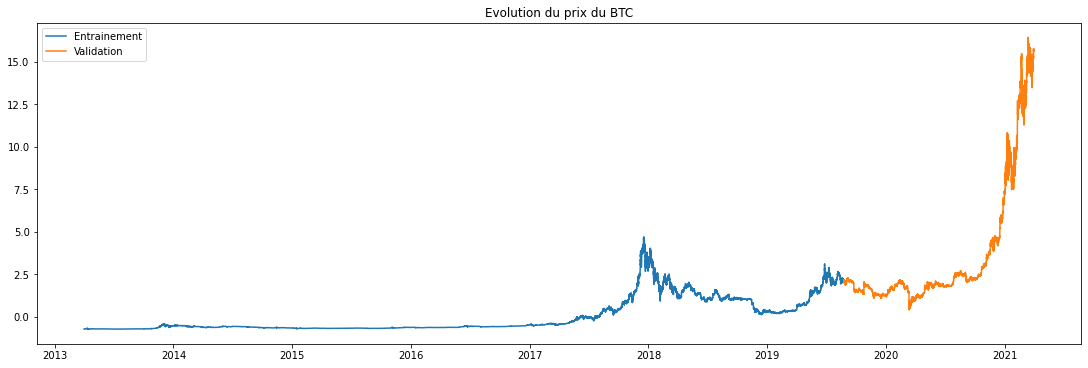

In [25]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(serie_entrainement, label="Entrainement")
ax.plot(serie_test,label="Validation")

ax.set_title("Evolution du prix du BTC")

ax.legend()
plt.show()

**2. Création des datasets**

In [36]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(serie, taille_fenetre, horizon, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (tf.expand_dims(x[0:taille_fenetre],axis=1),x[-taille_fenetre:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [37]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 16
horizon = 1
batch_size = 1000

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [38]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

56
(1000, 16, 1)
(1000, 16)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [39]:
# Extrait les X,Y du dataset
#56x((1000,4,1),(1000,1)) => (56*1000,4,1) ; (56*1000,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (56,1000,4,1) => (56*128,4,1)
# (56,1000,1) => (56*128,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1],taille_fenetre)))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(56000, 16, 1)
(56000, 16)


Puis la même chose pour les données de validation :

In [40]:
# Extrait les X,Y du dataset_val

x,y = tuple(zip(*dataset_val))

# Recombine les données

x_val = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_val = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1],taille_fenetre)))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(14000, 16, 1)
(14000, 16)


# Création du modèle type Wavenet Multivarié

**1. Création du réseau**

In [41]:
from keras.layers import Conv1D
from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2
import keras.backend as K
from keras.engine import Input
from keras.engine import Model

In [42]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

In [43]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

In [80]:
input_shape = Input(shape=(16, 2))
tf.expand_dims(input_shape[:,:,1],2)

<KerasTensor: shape=(None, 16, 1) dtype=float32 (created by layer 'tf.expand_dims_14')>

In [91]:
def build_model_residual_block(x, i, s,filters, use_bias,res_l2):
        original_x = x
        # TODO: initalization, regularization?
        relu_out = CausalDilatedConv1D(filters, 2, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='relu', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model_couche_condition(x, output_bins, filters, use_bias,res_l2):
        original_x = x
        skip_conditions = []

        relu_out = CausalDilatedConv1D(filters, 2, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,1, 0), activation='relu',
                                       W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,0],2))

        skip_ = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_conditions.append(skip_)

        for i in range(1,output_bins-1):
          relu_out = CausalDilatedConv1D(filters, 2, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,i+1,0), activation='relu',
                                                    W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,i],2))

          skip_ = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
          skip_conditions.append(skip_)

        if output_bins > 1:
          out = layers.Add()(skip_conditions)
        else:
          out = skip_
        return out


def build_model(fragment_length, filters, output_bins, dilation_depth, stacks, use_skip_connections, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, output_bins), name='input_part')
#        if output_bins < 2:
#          raise ValueError("output_bins cannot be == 1")
        out = input_shape
        skip_connections = []

        for s in range(stacks):
            # Couche conditionnée
            out = build_model_couche_condition(out, output_bins,filters, use_bias, res_l2)

            # Couches intermédiaires
            for i in range(1, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, filters, use_bias, res_l2)
                skip_connections.append(skip_out)

        if use_skip_connections:
            out = layers.Add()(skip_connections)

        # Couche de sortie
        out = layers.Activation('linear', name="output_linear")(out)
        out = layers.Conv1D(output_bins, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        model = Model(input_shape, out)
        return model


**2. Construction du modèle**

In [92]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
nb_output_bins = 1
dilation_depth = 3
nb_stacks = 1
use_skip_connections = False
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, nb_output_bins, dilation_depth, nb_stacks, use_skip_connections, use_bias, res_l2, final_l2)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_42 (Sl (None, 16)           0           input_part[0][0]                 
__________________________________________________________________________________________________
tf.expand_dims_27 (TFOpLambda)  (None, 16, 1)        0           tf.__operators__.getitem_42[0][0]
__________________________________________________________________________________________________
dilated_conv_1_condition_1_s0 ( (None, 16, 2)        6           tf.expand_dims_27[0][0]          
____________________________________________________________________________________________

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [93]:
max_periodes = 10000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10,
    decay_rate=0)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-7,periodes = 10, term="My_MSE")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="val_My_MSE")])


Epoch 1/10000
56/56 [==============================] - 3s 35ms/step - loss: 0.1608 - mse: 0.1608 - My_MSE: 3287.8450 - val_loss: 0.5998 - val_mse: 0.5998 - val_My_MSE: 4861.0928

Epoch 00001: loss improved from inf to 0.07143, saving model to poids_train.hdf5
Epoch 2/10000
56/56 [==============================] - 2s 28ms/step - loss: 0.0170 - mse: 0.0170 - My_MSE: 2772.4784 - val_loss: 0.4800 - val_mse: 0.4800 - val_My_MSE: 4431.6533

Epoch 00002: loss improved from 0.07143 to 0.01573, saving model to poids_train.hdf5
Epoch 3/10000
56/56 [==============================] - 2s 28ms/step - loss: 0.0125 - mse: 0.0125 - My_MSE: 2756.1967 - val_loss: 0.3599 - val_mse: 0.3599 - val_My_MSE: 4001.1882

Epoch 00003: loss improved from 0.01573 to 0.01169, saving model to poids_train.hdf5
Epoch 4/10000
56/56 [==============================] - 2s 28ms/step - loss: 0.0092 - mse: 0.0092 - My_MSE: 2744.3700 - val_loss: 0.2548 - val_mse: 0.2548 - val_My_MSE: 3624.7017

Epoch 00004: loss improved from 0

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions**

In [ ]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

**4.Affichage sur une période de 1 heure**

Création d'une série contenant les valeurs originales et les prédictions, synchronisées dans le temps :

In [ ]:
pred_ent[:,15,0]

In [ ]:
serie_btc_ent_ori = serie_entrainement*std+mean
serie_btc_val_ori = serie_test*std+mean

serie_btc_ent_pred = pd.Series(data=(pred_ent[:,15,0]*std+mean),index=y_train_timing)
serie_btc_val_pred = pd.Series(data=(pred_val[:,15,0]*std+mean),index=y_val_timing)

serie_btc_ori = pd.concat([serie_btc_ent_ori,serie_btc_val_ori])
serie_btc_pred = pd.concat([serie_btc_ent_pred,serie_btc_val_pred])

serie_btc_ori = serie_btc_ori.fillna(method="backfill")
serie_btc_pred = serie_btc_pred.fillna(method="backfill")

serie_btc_ent_ori = serie_btc_ent_ori.fillna(method="backfill")
serie_btc_val_ori = serie_btc_val_ori.fillna(method="backfill")
serie_btc_ent_pred = serie_btc_ent_pred.fillna(method="backfill")
serie_btc_val_pred = serie_btc_val_pred.fillna(method="backfill")

frame = {'BTC_ALL' : serie_btc_ori, 'BTC_ENT': serie_btc_ent_ori, 'BTC_VAL' : serie_btc_val_ori, 'BTC_PRED' : serie_btc_pred, 'BTC_PRED_ENT' : serie_btc_ent_pred, 'BTC_PRED_VAL':serie_btc_val_pred}
df_resultats = pd.DataFrame(frame)
df_resultats

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()